In [7]:
# Standard library imports
import csv
import html
import os
import re
from collections import defaultdict
from datetime import datetime
import sys

# Third-party library imports
import ftfy
import geonamescache
import locationtagger
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import psutil
import regex
import importlib
import seaborn as sns
import spacy
from joblib import Parallel, delayed
from langdetect import detect_langs, LangDetectException, DetectorFactory
from unidecode import unidecode

# Local application/library specific imports
sys.path.insert(0, '../Utility files')
import utils2

## Filtering, Preprocessing, and Language and Location Detection

This markdown contains the initial data cleaning and filters applied to the data.



Markdown overview:
1. Data Inspection and duplicate removal 
    - Summary statistics of users and brands.
    - Any missing data, duplicates etc.

2. Filters to match the SES embedding method:
    On the marker-follower (edgelist) df:
    - Remove users that follow less than 5 (or more) brands
    - Match the Follower_Ids in the now filtered marker-follower df with the follower-bio df. As such, the follower bios will only include users that follow more than five brands. Subsequent filters will be on the correct users (up to date follower-bios).

    On the follower-bios df:
    - Remove users with less than 25 followers
    - Remove users with less than 100 tweets
    - Clean the description column (normalise, remove emojis etc.)
    - Save the processed dfs so far

3. Keep only french accounts
    - Keep only users who have both french bios and a location that can be surely detected to be in France


Data sets:
- Markers' bios and metadata (markers_bios)
- Followers' bios and metadata (followers_bios)
- All brands and their followers (markers-followers)




### Load files 

In [8]:
# Load the data df of markers and their followers

# Load markers-followers (later referred to as edgelist)
load_path = '/home/livtollanes/SocialMarkers'
file = 'markers_followers_2023-05-19.csv'
file_path = os.path.join(load_path, file)

req_cols = ['id', 'follower_id']
dtypes = {'id': 'object',
          'follower_id': 'object'}

# Use pandas to load the csv file
markers_followers = pd.read_csv(file_path, usecols=req_cols, dtype=dtypes)

# Rename the twitter id column to follower id 
markers_followers.rename(columns={'id':'marker_id'}, inplace=True)

KeyboardInterrupt: 

In [4]:
# Load the followers bios and rename ID columns
load_path = '/home/livtollanes/SocialMarkers'
file = 'markers_followers_bios_2023-05-19.csv'
file_path = os.path.join(load_path, file)

req_cols = ['twitter_id', 'id', 'screen_name', 'description', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists','timestamp_utc']

dtypes = {
    'twitter_id': 'object',
    'id': 'object',
    'screen_name': 'object',
    'description': 'object',
    'location': 'object',
    'tweets': 'float64',
    'followers': 'float64',
    'friends': 'float64',
    'witheld_in_countries': 'float64'
}

# Use pandas to load the csv file
followers_bios = pd.read_csv(file_path, usecols=req_cols, dtype=dtypes)

# Rename the twitter id column to follower id 
followers_bios.rename(columns={'twitter_id':'follower_id'}, inplace=True)

## 1. Data Inspection and Duplicate Removal

- There are 2,357,493 duplicate rows in the edgelist

In [5]:
#Inspection of the data
utils2.summary_stats(followers_bios, print_dtypes=False)
importlib.reload(utils2)
utils2.summary_stats(markers_followers, print_dtypes=False)

Shape of DataFrame:  (70666646, 11)

Columns in DataFrame:  ['follower_id', 'id', 'screen_name', 'description', 'timestamp_utc', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists']

Number of unique values in 'follower_id':  70666646
Number of duplicate values in 'follower_id':  0

Number of unique values in 'id':  70642661
Number of duplicate values in 'id':  23984

Number of missing values in each column:
'follower_id':  0
'id':  23985
'screen_name':  23986
'description':  42027215
'timestamp_utc':  23985
'location':  47956041
'tweets':  23985
'followers':  23985
'friends':  23985
'likes':  23985
'lists':  23985

Number of duplicate rows:  0


In [8]:
# # Duplicate inspection - do they look like duplicates?

# # Sort the DataFrame to ensure that duplicates are next to each other
# markers_followers_sorted = markers_followers.sort_values(by=list(markers_followers.columns))

# # Find duplicates in the sorted DataFrame
# duplicates = markers_followers_sorted[markers_followers_sorted.duplicated(keep=False)]

# # Print the first 10 rows of duplicates (5 pairs)
# print(duplicates.head(10))

#drop the duplicates in markers_followers
markers_followers.drop_duplicates(keep='first', inplace=True)

         marker_id          follower_id
81032594  25053299            100000025
89256298  25053299            100000025
79323950  25053299  1000001004220420096
87547795  25053299  1000001004220420096
79369517  25053299  1000001771266232320
87593356  25053299  1000001771266232320
79562687  25053299           1000001815
87786516  25053299           1000001815
79371019  25053299  1000002790238777352
87594858  25053299  1000002790238777352


In [10]:
#Does the follower bio df contain the same followers as the edgelist?
utils2.compare_column_values(followers_bios, markers_followers, 'follower_id') # Yes

There are 30351 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


## 2. Filters to match the SES embedding method implementation

- Filter the marker-follower df:
    - Remove users that follow less than 5 (or more) brands
    - Streamline the edgelist df and the follower bio df so that any filters applied to one df is reflected in the other

- Filter the followers-bios df:
    - Remove users witrh less than 25 followers
    - Remove users with less than 100 tweets
    - Clean the description column. (Remove emojis, weird characters etc.)

#### Marker-follower df filtering

In [16]:
# Remove users that follow less than 5 brands
n = 5  # minimal number of brands followed required to be included in the analysis
markers_followers_5 = utils2.filter_followers(markers_followers, 'follower_id', n)

KeyboardInterrupt: 

In [12]:
### What brands were removed in the process?

# Get the unique marker_id values in the original and filtered DataFrames
original_brands = set(markers_followers['marker_id'].unique())
filtered_brands = set(markers_followers_5['marker_id'].unique())

# Find the brands that are in the original DataFrame but not in the filtered DataFrame
removed_brands = original_brands - filtered_brands

# Print the removed brands
print("Removed brands:", removed_brands) #corresponds to "Napapijiri97", which kinda sounds like a fake profile


# Streamline the follower bio df to be streamlined with the filter applied to the edgelist
followers_bios_5 = utils2.streamline_IDs(source = markers_followers_5, df_tofilter= followers_bios, column = 'follower_id')


utils2.compare_column_values(followers_bios_5, markers_followers_5, 'follower_id')   # The two dfs are streamlined so far

Removed brands: {'1059975643'}


#### Follower-bios filtering:
- Remove users with less than 25 followers
- Remove users with less than 100 tweets
- Update the markers-followers df to match the now filtered bio df

In [18]:
# Minimum of 25 followers and 100 tweets
followers_bios_fullfilter = utils2.filter_by_tweets_and_followers(followers_bios_5, min_followers= 25, min_tweets= 100)


#Streamline dfs again
markers_followers_fullfilter = utils2.streamline_IDs(source= followers_bios_fullfilter, df_tofilter=markers_followers_5, column='follower_id')

utils2.compare_column_values(followers_bios_fullfilter, markers_followers_fullfilter , 'follower_id') # dfs are streamlined

Removed 2750559 rows.
1192532 rows are left.


In [21]:
utils2.summary_stats(markers_followers_fullfilter, print_dtypes=False)

Shape of DataFrame:  (9614122, 2)

Columns in DataFrame:  ['marker_id', 'follower_id']

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique values in 'marker_id':  235
Number of duplicate values in 'marker_id':  9613887

Number of missing values in each column:
'marker_id':  0
'follower_id':  0

Number of duplicate rows:  0


In [22]:
#Before writing to csv, clean description column to avoid writing problems
followers_bios_fullfilter = utils2.process_description(followers_bios_fullfilter, 'description')

# #Now write the two dfs to csvs to save them in case something happens
# markers_followers_fullfilter.to_csv('/home/livtollanes/NewData/markers_followers_cleaned_nolang.csv', encoding='utf-8', index=False)

# followers_bios_fullfilter.to_csv('/home/livtollanes/NewData/followers_bios_cleaned_nolang3.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

## 3. Language Filtering: keep only french accounts
- We only want french language bios to be included in further analyses


#### Load data and double check for errors

In [22]:
#Load the filtered edgelist 
full_path1 = '/home/livtollanes/NewData/markers_followers_cleaned_nolang.csv'
req_cols = ['marker_id', 'follower_id']
dtypes = {'marker_id': 'object',
          'follower_id': 'object'}

markers_followers_clean = pd.read_csv(full_path1, encoding='utf-8', dtype=dtypes, usecols=req_cols)

In [23]:
# #Loading the cleaned and filtered followers bios 
full_path = '/home/livtollanes/NewData/followers_bios_cleaned_nolang3.csv'

req_cols = ['follower_id', 'screen_name', 'description', 'description_cleantext', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists','timestamp_utc']

dtypes = {
    'follower_id': 'object',
    'screen_name': 'object',
    'description': 'object',
    'description_cleantext': 'object',
    'location': 'object',
    'tweets': 'float64',
    'followers': 'float64',
    'friends': 'float64'
}

follower_bios_cleaned3 = pd.read_csv(full_path, usecols=req_cols, dtype=dtypes, engine= 'python')

In [24]:
utils2.compare_column_values(follower_bios_cleaned3, markers_followers_clean, 'follower_id') #The follower_ids are still streamlined, indicating that writing and reading of the cleaned dfs was successful

#summary stats on the dfs again, to make sure that no strange things have happened during the cleaning process
utils2.summary_stats(follower_bios_cleaned3, print_dtypes= False)
utils2.summary_stats(markers_followers_clean, print_dtypes= False)

#everything looks fine

There are 0 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


#### The language detection

The language detection is performed with the langdetect package. This package is based on Google's language detection API. On medium, it is actually reported that this package may not perform very accurate on short or mixed lnaguage texts, which is exactly what we are deailing with in twitter bios. However, upon comparison with Gcld3, langdetect was better. The comparison is not included in the current df, but the code is retained in the Wrangling2_old_no_deletion.ipynb file. 


In [27]:
# Create a copy of the DataFrame for each function
follower_bios_cleaned3_copy1 = follower_bios_cleaned3.copy()

# Use the copied DataFrame in the functions. Add and detect language to the lang df
lang = utils2.add_and_detect_language(follower_bios_cleaned3_copy1, 'description_cleantext', seed = 3)


In [28]:
#Language stats
utils2.calculate_language_percentages(lang, 'language') 

French:  268853 ( 22.544719973971347 %)
English:  353236 ( 29.620672652809315 %)
Unknown:  327271 ( 27.443372588743948 %)
Other:  243172 ( 20.39123478447538 %)
NaN in description_cleantext:  313934 ( 26.324995891095586 %)


In [29]:
# Overview of number of users with bios and locations
utils2.location_bio_stats(lang)

Unique locations: 231725 (19.4%)
Users with location data: 815847 (68.4%)
Users without location data: 376685 (31.6%)
Users with bios: 878598 (73.7%)
Users without bios: 313934 (26.3%)
Users with both location and bios: 668947 (56.1%)


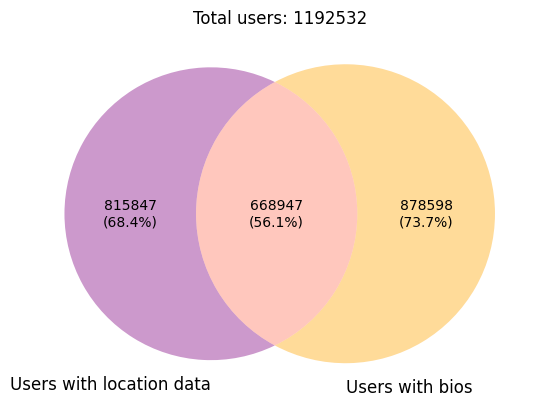

In [30]:
#Plot the intersection of users with bios and locations

# Calculate the number of users for each category
total_users = lang.shape[0]
users_with_location = lang['location'].notna().sum()
users_with_bios = lang['description_cleantext'].notna().sum()
users_with_both = lang[(lang['location'].notna()) & (lang['description_cleantext'].notna())].shape[0]

# Create the Venn diagram with custom colors
v = venn2(subsets=(users_with_location, users_with_bios, users_with_both),
    set_labels=('Users with location data', 'Users with bios'),
    set_colors=('purple', 'orange'))

# Calculate the percentages
location_percentage = users_with_location / total_users * 100
bios_percentage = users_with_bios / total_users * 100
both_percentage = users_with_both / total_users * 100

# Modify the labels of the subsets to include the percentages
v.get_label_by_id('10').set_text(f'{users_with_location}\n({location_percentage:.1f}%)')
v.get_label_by_id('01').set_text(f'{users_with_bios}\n({bios_percentage:.1f}%)')
v.get_label_by_id('11').set_text(f'{users_with_both}\n({both_percentage:.1f}%)')

# Add the total number of users to the title
plt.title(f'Total users: {total_users}')

plt.show()

Location (country) search using GeonamesCache

In [44]:
gc = geonamescache.GeonamesCache()
all_cities = gc.get_cities()

# Filter cities by country code
cities = {k: v for k, v in all_cities.items() if v['countrycode'] == 'FR'}

# Convert the cities dictionary to a list of tuples
cities_list = [(city['name'], city['population']) for city in cities.values()]

# Sort the list by population in descending order and take the first 1000
biggest_cities = sorted(cities_list, key=lambda x: x[1], reverse=True)[:652]

# Print the  biggest cities
for city, population in biggest_cities:
    print(city, population)

Paris 2138551
Marseille 870731
Lyon 522969
Toulouse 493465
Nice 342669
Nantes 318808
Strasbourg 274845
Bordeaux 260958
Montpellier 248252
Rouen 234475
Lille 234475
Rennes 220488
Reims 196565
Le Havre 185972
Cergy-Pontoise 183430
Saint-Étienne 176280
Toulon 168701
Angers 168279
Grenoble 158552
Dijon 158002
Nîmes 148236
Clermont-Ferrand 147865
Aix-en-Provence 146821
Saint-Quentin-en-Yvelines 146598
Brest 144899
Le Mans 144515
Amiens 143086
Tours 141621
Limoges 141176
Villeurbanne 131445
Besançon 128426
Metz 123914
Orléans 116269
Mulhouse 111430
Montreuil 111240
Perpignan 110706
Caen 110624
Boulogne-Billancourt 108782
Nancy 105058
Lyon 03 102725
Argenteuil 101475
Roubaix 98828
Tourcoing 98656
Saint-Denis 96128
Avignon 89769
Marseille 13 89316
Asnières-sur-Seine 86742
Nanterre 86719
Lyon 08 86154
Poitiers 85960
Versailles 85416
Courbevoie 85158
Créteil 84833
Pau 82697
Lyon 07 82573
Colombes 82300
Vitry-sur-Seine 81001
Aulnay-sous-Bois 80615
Marseille 08 78837
Marseille 15 77770
Marseille 0

In [32]:
# Extract city names from biggest_cities list
city_names = [city[0] for city in biggest_cities]

# Add 'france' to the list of city names
city_names.append('france')

# Convert all city names to lowercase to ignore case
city_names = [city.lower() for city in city_names]

# Convert location column to lowercase to ignore case
lang['location'] = lang['location'].str.lower()


In [35]:
# Based on the location column, assign either country France or other 
# Apply the function to the 'location' column and assign the result to a new 'country' column
lang['country'] = lang['location'].apply(lambda x: utils2.assign_country(x, city_names))

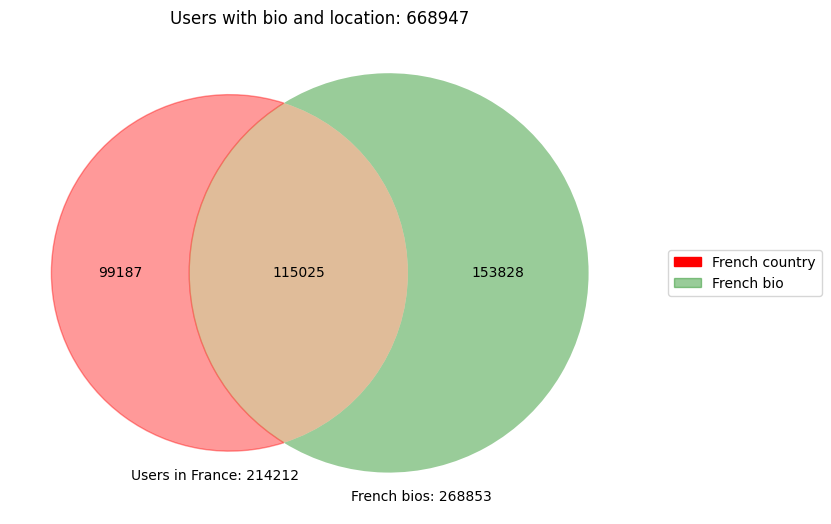

In [36]:
# Calculate the intersections - bios and locations
french_country_french_language = lang[(lang['country'] == 'France') & (lang['language'] == 'fr')].shape[0]
french_country_other_language = lang[(lang['country'] == 'France') & (lang['language'] != 'fr')].shape[0]

french_country = lang[lang['country'] == 'France'].shape[0]
french_bio = lang[lang['language'] == 'fr'].shape[0]

users_with_both = lang[(lang['location'].notna()) & (lang['description_cleantext'].notna())].shape[0]

# Define the set sizes and the intersection sizes
venn_labels = {'10': french_country_other_language, 
               '01': french_bio - french_country_french_language, 
               '11': french_country_french_language}

# Calculate the total number of users
total_users = users_with_both

plt.figure(figsize=(8, 8))
venn = venn2(subsets=venn_labels, set_labels=(None, None))

# Set 'French country' to red
venn.get_patch_by_id('10').set_color('red')

# Add a title
plt.title(f'Users with bio and location: {total_users}')

# Create the legend
french_country_patch = mpatches.Patch(color='red', label='French country')  # Set 'French country' to red in the legend
french_language_patch = mpatches.Patch(color=venn.get_patch_by_id('01').get_facecolor(), label='French bio')
plt.legend(handles=[french_country_patch, french_language_patch], bbox_to_anchor=(1.05, 0.5), loc='center left')

# Add the total count per category underneath each circle
plt.text(-0.25, -0.5, f'Users in France: {french_country}', ha='center')
plt.text(0.25, -0.55, f'French bios: {french_bio}', ha='center')

# Display the plot
plt.show()

#The numbers change abit each time the language detection is ran, because I did not set a seed and the language detection is probabilistic

In [39]:
#separate dfs for the different categories
french_bio_not_france = lang[(lang['language'] == 'fr') & (lang['country'] != 'France')]
in_france_nofrenc_bio = lang[(lang['language'] != 'fr') & (lang['country'] == 'France')]
bio_and_country = lang[(lang['language'] == 'fr') & (lang['country'] == 'France')]

In [42]:
# # how many rows in french_bio_not_france in the column location are NA?
# french_bio_not_france['location'].isna().sum()

# #print a selected interval of the rows in french_bio_not_france that are NA in location
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
# french_bio_not_france[french_bio_not_france['location'].isna()][['description_cleantext', 'language', 'location', 'country']].iloc[20:30]

,description_cleantext,language,location,country
280,Quand le silence devient notre seule option...!!!!!,fr,NaN,Other
307,Tout £st possible à celui qui cΠoi,fr,NaN,Other
315,Ex président de la fédération des buralistes d'Ile de France,fr,NaN,Other
374,Co-créateur du projet @transmission_s_ Salarié de la protection de l'enfance Militant #Paris13 Acteur dans la troupe des @amis_1871,fr,NaN,Other
394,"du soleil, des fleurs, du rock et beaucoup d’amour",fr,NaN,Other
405,Artiste peintre et écrivain en art spirituel divine et sculpteur,fr,NaN,Other
418,Rien d'spécial,fr,NaN,Other
420,Life is a Joke. Vie ta vie au jour le jour. BrunoMars.Instagram&Snapchat: jujubb2,fr,NaN,Other
438,"Journaliste France Culture, Vannes - Paris Paris - Vannes du reportage ici et là-bas.",fr,NaN,Other
441,Head of Marketing Communication Passionné par l’artisanat et le design ! #HigherEd #cobranding #mode #couture #luxe,fr,NaN,Other


In [23]:
# #Write the language df to csv to save it in case something happens
# bio_and_country.to_csv('/home/livtollanes/NewData/french/french1.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)